# 1. 기본 설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pycaret

In [ ]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

plt.rc('font', family='Gulim')

# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
# 여러가지 머신러닝 모델을 가지고 있는 라이브러리 *가장 많이 사용*
import sklearn
# 공통 모듈 임포트
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split


# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 1.1 데이터 가져오기

In [ ]:
###data불러오기
train = pd.read_csv('/content/drive/MyDrive/energy/train.csv',encoding = 'euc-kr')
test = pd.read_csv('/content/drive/MyDrive/energy/test.csv',encoding = 'euc-kr')
submission = pd.read_csv('/content/drive/MyDrive/energy/sample_submission.csv',encoding = 'euc-kr')

In [ ]:
####test null 값 채우는 함수
def test_null(test,train):
  ###선형보간을 위한 base data /col= '비전기냉방설비운영', '태양광보유'
  train = train[['num','비전기냉방설비운영', '태양광보유']].drop_duplicates()
  ###선형보간으로 채우기 때문에 test에 드랍
  test = test.drop(['비전기냉방설비운영', '태양광보유'],axis=1)
  test = pd.merge(test, train, on= 'num')
  ###나머지 null 채우기
  test.interpolate(method='linear',inplace=True)
  return test

test = test_null(test,train)

In [ ]:
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   num         122400 non-null  int64  
 1   date_time   122400 non-null  object 
 2   전력사용량(kWh)  122400 non-null  float64
 3   기온(°C)      122400 non-null  float64
 4   풍속(m/s)     122400 non-null  float64
 5   습도(%)       122400 non-null  float64
 6   강수량(mm)     122400 non-null  float64
 7   일조(hr)      122400 non-null  float64
 8   비전기냉방설비운영   122400 non-null  float64
 9   태양광보유       122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


In [ ]:
train.isnull().sum()

num           0
date_time     0
전력사용량(kWh)    0
기온(°C)        0
풍속(m/s)       0
습도(%)         0
강수량(mm)       0
일조(hr)        0
비전기냉방설비운영     0
태양광보유         0
dtype: int64

In [ ]:
###test결측값 확인 - 선형보간법으로 채움
test.isnull().sum()

num             0
date_time       0
기온(°C)          0
풍속(m/s)         0
습도(%)           0
강수량(mm, 6시간)    0
일조(hr, 3시간)     0
비전기냉방설비운영       0
태양광보유           0
dtype: int64

# 1.2 결측치

In [ ]:
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [ ]:
test.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.800000,1.500000,74.000000,0.0,0.0,0.0,0.0
1,1,2020-08-25 01,27.633333,1.366667,75.333333,0.0,0.0,0.0,0.0
2,1,2020-08-25 02,27.466667,1.233333,76.666667,0.0,0.0,0.0,0.0
3,1,2020-08-25 03,27.300000,1.100000,78.000000,0.0,0.0,0.0,0.0
4,1,2020-08-25 04,26.900000,1.166667,79.666667,0.0,0.0,0.0,0.0


In [ ]:
def data_prepared(data,kind="train"):
  #date_time 형식 datetime 형식으로 변환
  data['date_time'] = pd.to_datetime(data['date_time'])
  if kind == "train":
    data = data.sort_values("date_time")
    data = data.reset_index(drop=True)
  #datetime 월/일/요일/시
  data["월"] = data["date_time"].dt.month
  data["일"] = data["date_time"].dt.day
  data["요일"] = data["date_time"].dt.weekday
  data["시"] = data["date_time"].dt.hour
  #주말
  data["주말여부"] = data["요일"].isin([5,6])
  #공휴일(8/17) 추출
  index_0817 = data.loc[data["date_time"] == "2020-08-17"].index
  data["주말여부"].iloc[index_0817] = True
  #불쾌지수
  data['불쾌지수'] = 1.8*data['기온(°C)'] - 0.55*(1-(data['습도(%)']/100))*(1.8*data['기온(°C)']-26) + 32
  data['불쾌지수_범주']=pd.cut(data['불쾌지수'],bins=[50,68,75,80,90],labels=['낮음','보통','높음','매우높음'])
  data = data.drop(['date_time',"불쾌지수"],axis=1)
  #요일 범주형으로 변환
  data["요일"] = data["요일"].astype("str")
  #주말여부 0,1로 변환
  data["주말여부"] = data["주말여부"].astype("int")
  return data

In [ ]:
train_prepared = data_prepared(train)
train_prepared.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,num,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,월,일,요일,시,주말여부,불쾌지수_범주
0,1,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,6,1,0,0,0,낮음
1,34,530.388,17.6,2.5,92.0,0.8,0.0,1.0,1.0,6,1,0,0,0,낮음
2,35,553.824,17.1,2.6,94.0,0.1,0.0,1.0,0.0,6,1,0,0,0,낮음
3,36,797.472,18.5,1.3,95.0,0.0,0.0,0.0,1.0,6,1,0,0,0,낮음
4,37,1476.720,19.9,1.9,60.0,0.0,0.0,1.0,1.0,6,1,0,0,0,낮음


In [ ]:
test_prepared = data_prepared(test,"test")
test_prepared

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,num,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,월,일,요일,시,주말여부,불쾌지수_범주
0,1,27.800000,1.500000,74.000000,0.0,0.000000,0.0,0.0,8,25,1,0,0,높음
1,1,27.633333,1.366667,75.333333,0.0,0.000000,0.0,0.0,8,25,1,1,0,높음
2,1,27.466667,1.233333,76.666667,0.0,0.000000,0.0,0.0,8,25,1,2,0,높음
3,1,27.300000,1.100000,78.000000,0.0,0.000000,0.0,0.0,8,25,1,3,0,높음
4,1,26.900000,1.166667,79.666667,0.0,0.000000,0.0,0.0,8,25,1,4,0,높음
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,60,28.633333,3.566667,66.000000,0.0,0.533333,1.0,1.0,8,31,0,19,0,높음
10076,60,28.266667,3.833333,67.000000,0.0,0.266667,1.0,1.0,8,31,0,20,0,높음
10077,60,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0,8,31,0,21,0,높음
10078,60,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0,8,31,0,22,0,높음


# 2. EDA

# 2.1 태양광보유[범주형]

In [ ]:
train_prepared['태양광보유'].describe()

NameError: ignored

In [ ]:
train_prepared['태양광보유'].value_counts()

NameError: ignored

In [ ]:
plt.figure(figsize=(10,5))
tr_df['태양광보유'].value_counts().sort_index(ascending=True).plot(kind='bar')
plt.xlabel('태양광보유')
plt.ylabel('count')
plt.title('태양광보유 빈도 파악')
plt.show()
## 태양광보유를 하지않은 건물은 63240 , 태양광보유를 한 건물은 총 59160로 보유하지 않은 건물이 더 많지만 별 차이가 없다.

NameError: ignored

<Figure size 720x360 with 0 Axes>

In [ ]:
attributes = ["전력사용량(kWh)","태양광보유"]
scatter_matrix(train_prepared[attributes], figsize=(12, 8))

In [ ]:
train_prepared.groupby(['태양광보유'])['전력사용량(kWh)'].mean()
#태양광을 보유하면 전력사용량이 줄어들 것이라고 예상하였지만 예상과 달리 태양광을 보유하였다고 하여 전력사용량이 줄어들지는 않았다.

# 2.2 일조(hr)[연속형]
-  태양 광선이 구름이나 안개로 가려지지 않고 땅 위를 비치는 것을 말하며, 실제로 비친 시간을 의미함


In [ ]:
train_prepared['일조(hr)'].describe()

count    122400.000000
mean          0.213533
std           0.370517
min           0.000000
25%           0.000000
50%           0.000000
75%           0.300000
max           1.000000
Name: 일조(hr), dtype: float64

In [ ]:
train_prepared['일조(hr)'].value_counts()

0.0    85394
1.0    15137
0.1     3376
0.9     3361
0.8     2385
0.7     2306
0.2     2228
0.3     2216
0.6     2083
0.4     2024
0.5     1890
Name: 일조(hr), dtype: int64

In [ ]:
plt.figure(figsize=(12,8))
tr_df['일조(hr)'].value_counts().sort_index(ascending=True).plot(kind='bar')
plt.xlabel('일조(hr)')
plt.ylabel('비율')
plt.title('시간당 일조량')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


In [ ]:
attributes = ["전력사용량(kWh)","일조(hr)"]
scatter_matrix(train_prepared[attributes], figsize=(12, 8))

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:185: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1d5012550>,
      dtype=object)

In [ ]:
train_prepared.groupby(['일조(hr)'])['전력사용량(kWh)'].mean()
#일조(hr)가 0.0일때 다른 값들보다 눈에 띄게 전력사용량이 적다는 것을 알 수 있다. 또, 일조(hr)가 1.0일때 전력사용량이 가장 많다는것을 알 수 있다.

일조(hr)
0.0    2156.362069
0.1    2700.693970
0.2    2685.707424
0.3    2674.739148
0.4    2624.644535
0.5    2708.593070
0.6    2686.305360
0.7    2674.550063
0.8    2695.807823
0.9    2744.056598
1.0    2744.500937
Name: 전력사용량(kWh), dtype: float64

# 2.3 주말여부[범주형]

In [ ]:
train_prepared['주말여부'].describe()

count     122400
unique         2
top        False
freq       87840
Name: 주말여부, dtype: object

In [ ]:
train_prepared['주말여부'].unique()

array([False,  True])

In [ ]:
train_prepared['주말여부'].value_counts()

False    87840
True     34560
Name: 주말여부, dtype: int64

In [ ]:
train_prepared["주말여부"] = train_prepared["주말여부"].astype(int)

train_prepared.head(10)

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,시,요일,달,날짜,주말여부
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,0,0,6,1,0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1,0,6,1,0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2,0,6,1,0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,3,0,6,1,0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,4,0,6,1,0
5,1,2020-06-01 05:00:00,8010.576,16.9,3.4,93.0,0.0,0.0,0.0,0.0,5,0,6,1,0
6,1,2020-06-01 06:00:00,7978.176,16.7,3.4,90.0,0.1,0.0,0.0,0.0,6,0,6,1,0
7,1,2020-06-01 07:00:00,8019.000,16.9,2.3,86.0,0.0,0.1,0.0,0.0,7,0,6,1,0
8,1,2020-06-01 08:00:00,8020.944,17.8,3.3,80.0,0.0,0.3,0.0,0.0,8,0,6,1,0
9,1,2020-06-01 09:00:00,8083.152,19.3,2.1,73.0,0.0,0.7,0.0,0.0,9,0,6,1,0


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47568 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50668 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48712 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_

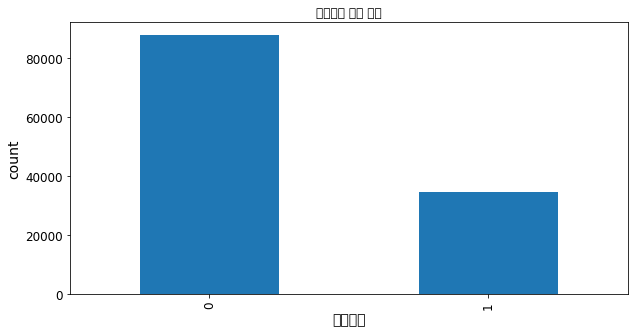

In [ ]:
plt.figure(figsize=(10,5))
train_prepared['주말여부'].value_counts().sort_index(ascending=True).plot(kind='bar')
plt.xlabel('주말여부')
plt.ylabel('count')
plt.title('주말여부 빈도 파악')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa2b9b93310>,
      dtype=object)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47141 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_

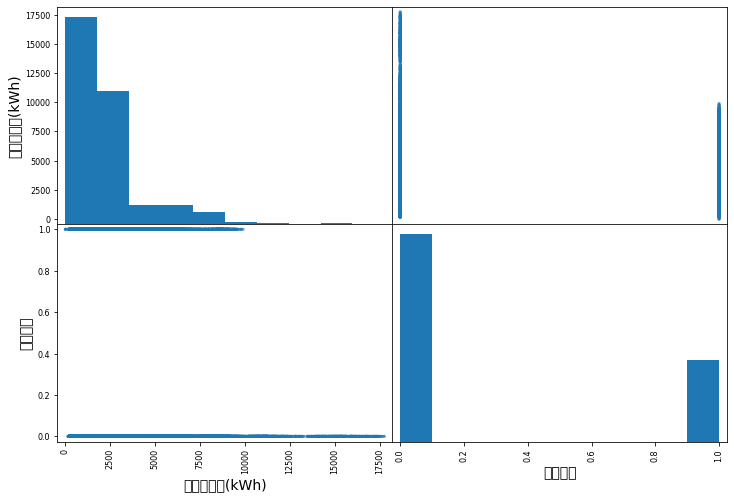

In [ ]:
attributes = ["전력사용량(kWh)","주말여부"]
scatter_matrix(train_prepared[attributes], figsize=(12, 8))

In [ ]:
train_prepared.groupby(['주말여부'])['전력사용량(kWh)'].mean()
#예상대로 대부분의 건물들의 전력사용량은 평일에 더 많은 것을 알 수 있다.

주말여부
0    2418.644266
1    2086.388473
Name: 전력사용량(kWh), dtype: float64

# 2.4 요일 EDA

In [ ]:
train_prepared.dtypes

num                    int64
date_time     datetime64[ns]
전력사용량(kWh)           float64
기온(°C)               float64
풍속(m/s)              float64
습도(%)                float64
강수량(mm)              float64
일조(hr)               float64
비전기냉방설비운영            float64
태양광보유                float64
시                      int64
요일                     int64
달                      int64
날짜                     int64
주말여부                   int64
dtype: object

In [ ]:
train_prepared['요일'].describe()

count    122400.000000
mean          2.964706
std           2.014351
min           0.000000
25%           1.000000
50%           3.000000
75%           5.000000
max           6.000000
Name: 요일, dtype: float64

In [ ]:
train_prepared['요일'].value_counts()

0    18720
6    17280
5    17280
4    17280
3    17280
2    17280
1    17280
Name: 요일, dtype: int64

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47141 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_

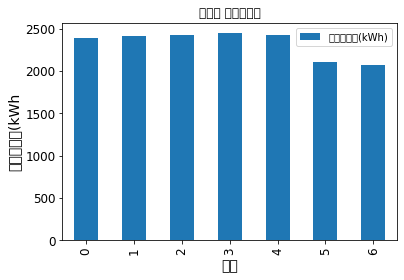

In [ ]:
a = train_prepared.groupby(['요일'])['전력사용량(kWh)'].mean()
a = pd.DataFrame(a)
a.plot(kind='bar')
plt.xlabel('요일')
plt.ylabel('전력사용량(kWh')
plt.title('요일별 전력사용량')
plt.show()

#예상과 같이 주말에 전력 사용량이 줄어들음으로써 상관성 입증

# 2.5 강수량 EDA

In [ ]:
train_prepared['강수량(mm)'].describe()

count    122400.000000
mean          0.514989
std           2.624505
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          81.500000
Name: 강수량(mm), dtype: float64

In [ ]:
train_prepared['강수량(mm)'].value_counts()

0.0     103473
0.1       2508
0.2       1644
0.3       1171
0.5        830
         ...  
25.1         1
25.2         1
27.9         1
31.0         1
54.6         1
Name: 강수량(mm), Length: 296, dtype: int64

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48708 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50984 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_

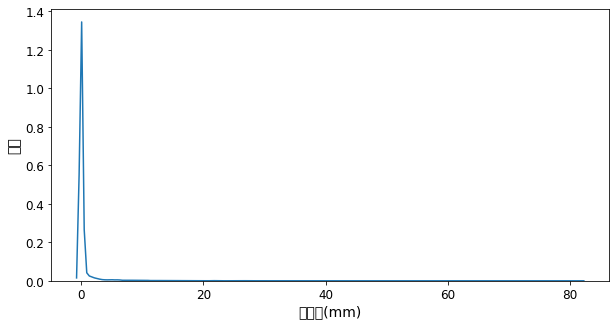

In [ ]:
# kdeplot
# 빈 캔버스 사이즈 지정
plt.figure(figsize=(10,5))

# 캔버스에 그림 그리기
kde=sns.kdeplot(train_prepared['강수량(mm)'])
kde.set_xlabel("강수량(mm)")
kde.set_ylabel("비율")


plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa2ae46fa10>,
      dtype=object)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47141 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_

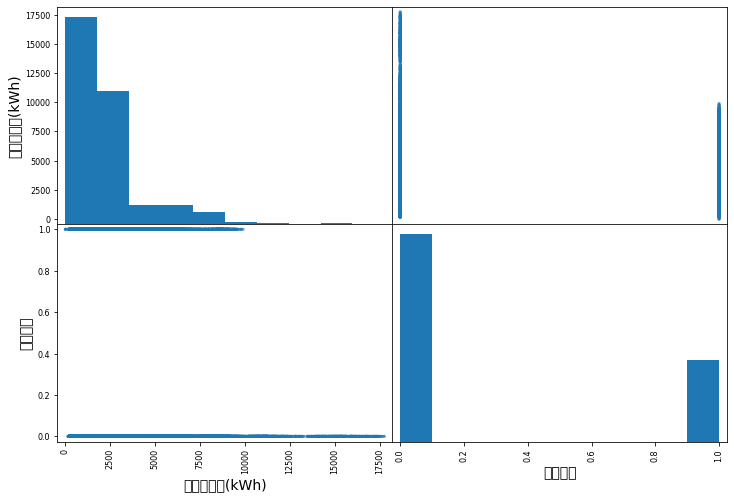

In [ ]:
attribues = ['전력사용량(kWh)','강수량(mm)']
scatter_matrix(train_prepared[attributes], figsize=(12,8))

In [ ]:
train_prepared.groupby(['강수량(mm)'])['전력사용량(kWh)'].mean()

강수량(mm)
0.0     2329.713419
0.1     2279.650063
0.2     2399.462277
0.3     2433.224677
0.4     2264.247383
           ...     
54.6     626.616000
54.8    2177.611714
61.4    2206.000286
70.4    1398.646286
81.5    2478.762000
Name: 전력사용량(kWh), Length: 296, dtype: float64

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47141 missing from current font.
  font.set_

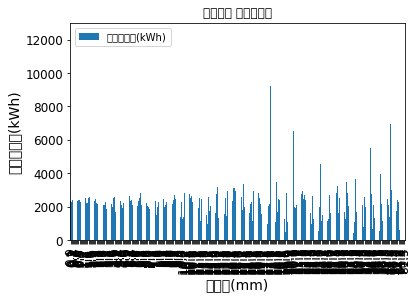

In [ ]:
b = train_prepared.groupby(['강수량(mm)'])['전력사용량(kWh)'].mean()
b=pd.DataFrame(b)
plt.rc('font', family='NanumBarunGothic')
b.plot(kind='bar')
plt.xlabel('강수량(mm)')
plt.ylabel('전력사용량(kWh)')
plt.title('강수량별 전력사용량')
plt.show()

#강수량과 전력사용량은 상관관계 적음

# 2.6 기온 EDA

In [ ]:
train_prepared['기온(°C)'].describe()

count    122400.000000
mean         24.251713
std           3.407902
min          11.100000
25%          21.800000
50%          24.200000
75%          26.500000
max          36.300000
Name: 기온(°C), dtype: float64

In [ ]:
train_prepared['기온(°C)'].value_counts()

25.0    1485
21.6    1470
25.1    1445
23.7    1438
24.1    1436
        ... 
12.3       1
13.5       1
36.3       1
35.8       1
12.0       1
Name: 기온(°C), Length: 245, dtype: int64

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48708 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50984 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_te

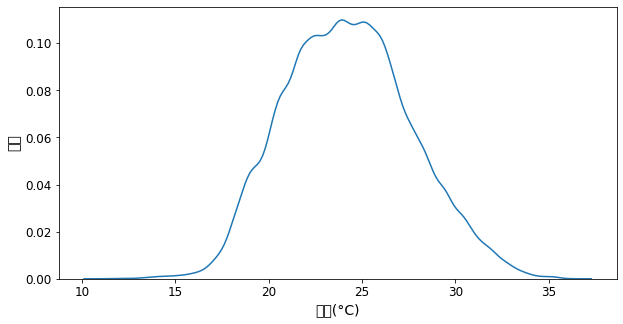

In [ ]:
# kdeplot
# 빈 캔버스 사이즈 지정
plt.figure(figsize=(10,5))

# 캔버스에 그림 그리기
kde=sns.kdeplot(train_prepared['기온(°C)'])
kde.set_xlabel("기온(°C)")
kde.set_ylabel("비율")

# 다 그려진 캔버스 보여주기
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa2b072a810>,
      dtype=object)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47141 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_

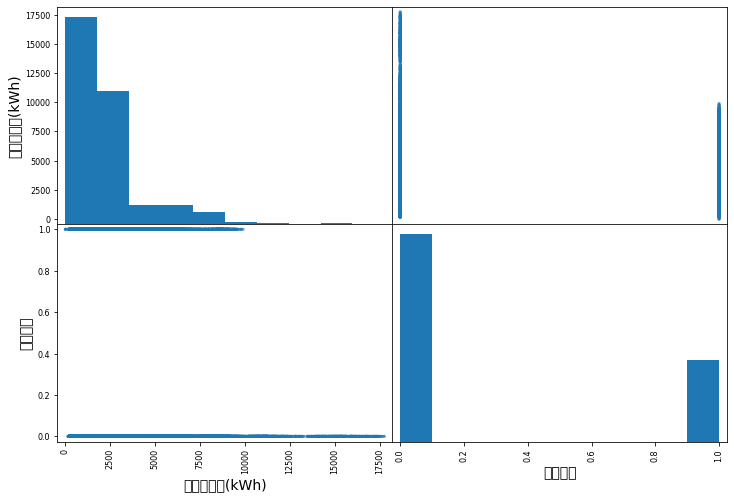

In [ ]:
attribues = ['전력사용량(kWh)','기온(°C)']
scatter_matrix(train_prepared[attributes], figsize=(12,8))

In [ ]:
train_prepared.groupby(['기온(°C)'])['전력사용량(kWh)'].mean()

기온(°C)
11.1     672.624
11.2     848.880
11.3     721.224
11.7     482.220
11.8     473.364
          ...   
35.6    1767.312
35.7    1554.282
35.8    1748.304
36.0    1505.088
36.3     930.528
Name: 전력사용량(kWh), Length: 245, dtype: float64

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47141 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_

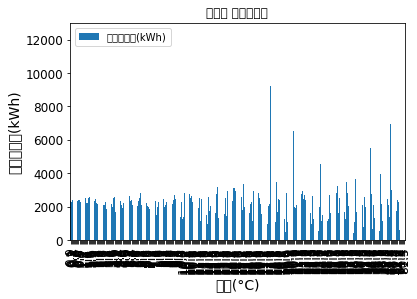

In [ ]:
c = train_prepared.groupby(['기온(°C)'])['전력사용량(kWh)'].mean()
c=pd.DataFrame(b)
plt.rc('font', family='NanumBarunGothic')
b.plot(kind='bar')
plt.xlabel('기온(°C)')
plt.ylabel('전력사용량(kWh)')
plt.title('기온별 전력사용량')
plt.show()

#기온의 변동이 전력사용량에 영향을 끼칠 것으로 예측했으나, 큰 연관성 없음

# 3. 건물별 그룹화

In [ ]:
# 60개의 건물 그룹화

# 여러 가지 변환을 위해 copy 후 진행
num_groups = train_prepared.groupby("num")

# 건물 번호 매칭을 위해 빈 리스트 하나 추가 후 진행
group_list = [[]]
for i in range(1,60+1):
  group_list.append(num_groups.get_group(i))

print(f"gropu_list 길이: {len(group_list)}")

gropu_list 길이: 61


In [ ]:
# 'num', '비전기냉방설비운영', '태양광보유' 제외
check_list = ['date_time', '전력사용량(kWh)', '기온(°C)', '풍속(m/s)', '습도(%)',
       '강수량(mm)', '일조(hr)', '시',	'요일',	'주말여부']

# 확인하고 싶은 건물 번호 넣어 확인
num=5

#!pip install dataprep
from dataprep.eda import create_report



# plot보다 더 자세한 결과들을 확인할 수 있습니다.
# variables에서 Show Details를 누르면 numerical 데이터는 다양한 plot을 categorical 데이터는 pie chart 등을 확인할 수 있습니다.
# Interactions에서 x,y 축에 살펴보고자 하는 변수를 입력하면 두 함수의 관계를 살펴볼 수 있고
# Correlations에선 Pearson, Spearman, KendallTau 각각의 상관계수를 볼 수 있습니다.
create_report(group_list[num][check_list])

ModuleNotFoundError: ignored

In [ ]:
tr_df.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,시,요일,달,날짜,dayofyear,주말여부,불쾌지수
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,0,0,6,1,153,False,63.43008
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1,0,6,1,153,False,63.56993
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2,0,6,1,153,False,63.22775
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,3,0,6,1,153,False,62.54339
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,4,0,6,1,153,False,62.39760


### 본격적인 분석에 앞서 시간의 흐름에 따라 데이터가 어떤 흐름을 보이는지 간단히 살펴보겠습니다.

In [ ]:
(tr_df.groupby(['dayofyear'])['기온(°C)'].mean()*100).plot(figsize=(30, 4))
tr_df.groupby(['dayofyear'])['전력사용량(kWh)'].mean().plot(figsize=(30, 4))
plt.legend(['기온(°C)', '전력사용량(kWh)'])
plt.title('일별 기온 및 전력사용량 추이')
plt.show()

# 8월말로 갈수록 기온이 상승한다는 것을 알 수 있고, 기온과 전력사용량이 비슷하게 흘러간다는 것을 알 수 있다.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48143 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_

In [ ]:
(tr_df.groupby(['dayofyear'])['기온(°C)'].mean()*100).plot(figsize=(30, 4))
tr_df.groupby(['dayofyear'])['전력사용량(kWh)'].mean().plot(figsize=(30, 4))
plt.legend(['기온(°C)', '전력사용량(kWh)'])
plt.title('일별 기온 및 전력사용량 추이')
plt.show()

# • 시간별 평균 전력사용량

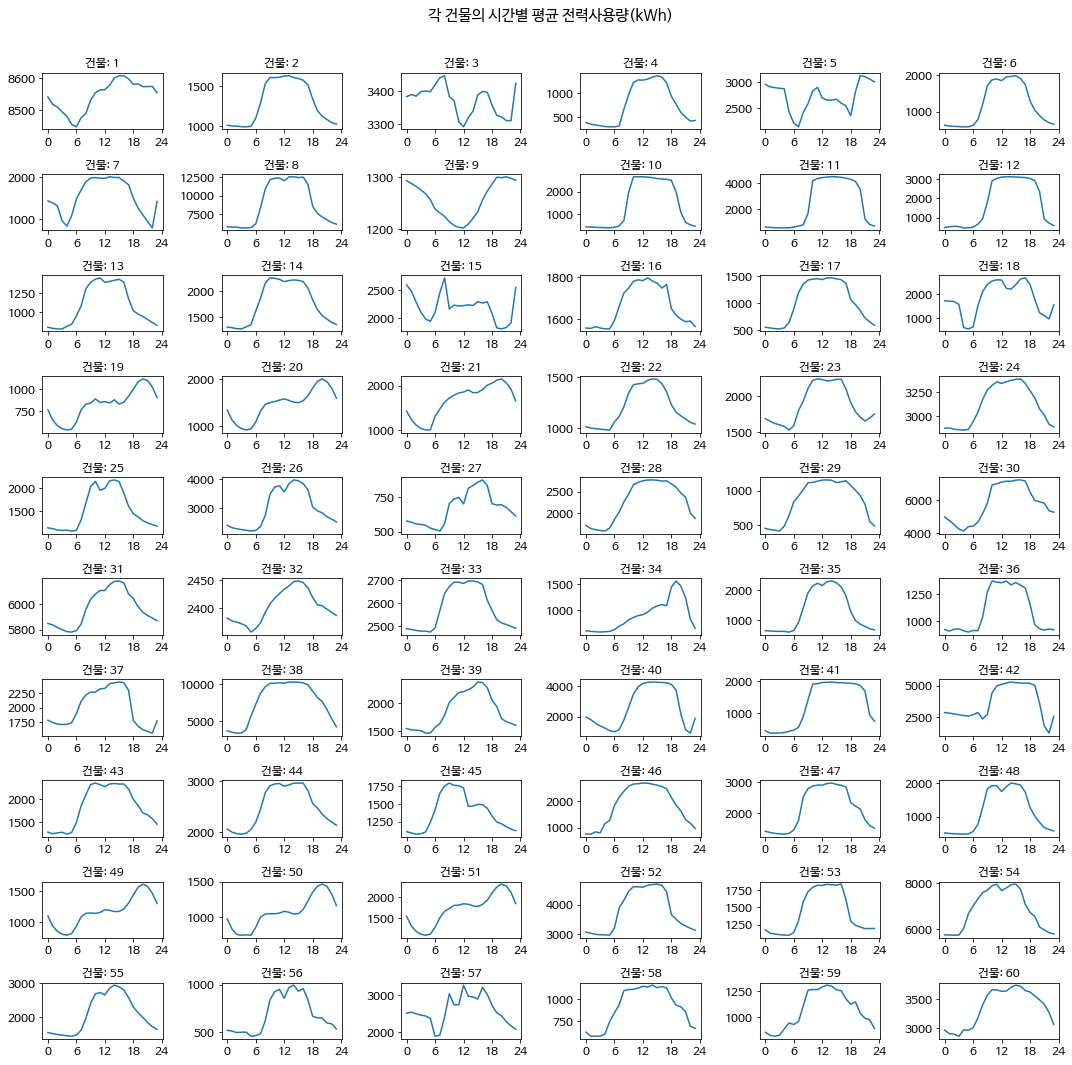

In [ ]:
fig = plt.figure(figsize = (15 ,15))
plt.title("각 건물의 시간별 평균 전력사용량(kWh)", fontsize=15, y=1.05)
plt.axis('off')

for num in range(1,61):
    df = train_prepared[train_prepared.num==num]
    ax = fig.add_subplot(10,6,num)
    ax.plot(df['시'].unique(), df.groupby('시')['전력사용량(kWh)'].mean())
    ax.set_title(f'건물: {num}')
    ax.set_xticks([0,6,12,18,24])
plt.tight_layout()
plt.show()

# • 요일별 평균 전력사용량

In [ ]:
fig = plt.figure(figsize = (15 ,15))
plt.title("각 건물의 요일별 평균 전력사용량(kWh)", fontsize=15, y=1.05)
plt.axis('off')


colors = ['skyblue','pink']

for num in range(1,61):
    df = train[train.num==num]
    df_counts = train_prepared.groupby('주말여부')['전력사용량(kWh)'].mean()

    ax = fig.add_subplot(10,6,num)
    ax.bar(tr_df['주말여부'].unique(), df_counts, color=colors)
    ax.set_title(f'건물: {num}')
plt.tight_layout()
plt.show()

# • 시간+요일별 평균 전력사용량

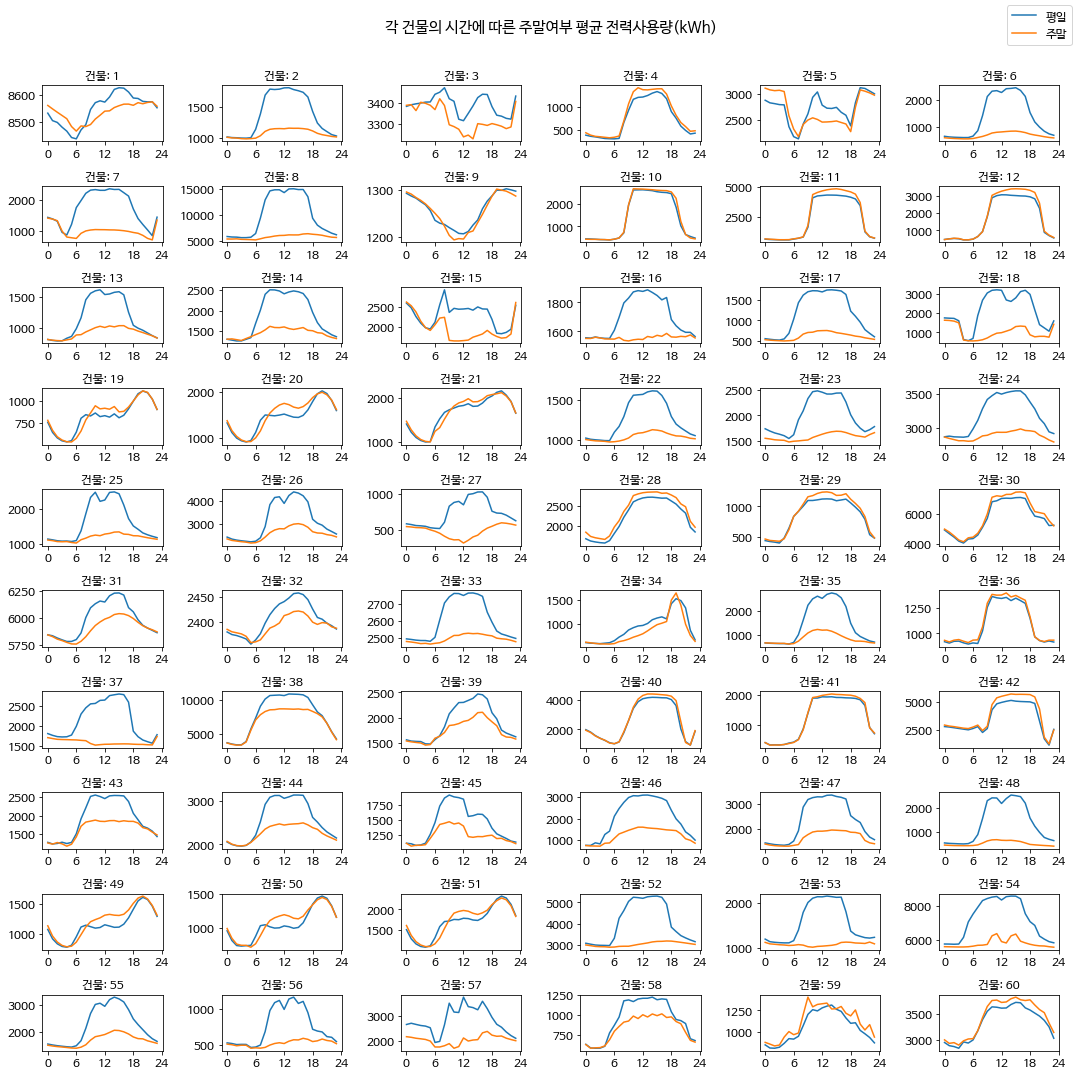

In [ ]:
fig = plt.figure(figsize = (15 ,15))
plt.title("각 건물의 시간에 따른 주말여부 평균 전력사용량(kWh)", fontsize=15, y=1.05)
plt.axis('off')

for num in range(1,61):
    df = train_prepared[train_prepared.num==num]
    ax = fig.add_subplot(10,6,num)
    ax.plot(df['시'].unique(), df[df.주말여부==0].groupby('시')['전력사용량(kWh)'].mean(), label='평일')
    ax.plot(df['시'].unique(), df[df.주말여부==1].groupby('시')['전력사용량(kWh)'].mean(), label='주말')
    ax.set_title(f'건물: {num}')
    ax.set_xticks([0,6,12,18,24])
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc = 1, prop={'size':12})
plt.tight_layout()
plt.show()

#상관관계

In [ ]:
train_prepared.corr()

,num,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,월,일,요일,시,주말여부
num,1.000000e+00,-0.063193,0.000363,-0.052184,0.005379,-0.004673,-0.013685,6.103135e-02,9.918068e-02,6.122079e-19,-9.080407e-19,-8.653233e-20,0.000000e+00,-5.954134e-20
전력사용량(kWh),-6.319335e-02,1.000000,0.158361,0.109965,-0.077199,-0.006028,0.112131,1.507991e-01,1.163441e-01,5.214575e-02,1.318781e-02,-5.375855e-02,9.147217e-02,-7.279966e-02
기온(°C),3.631250e-04,0.158361,1.000000,0.167455,-0.509105,-0.093788,0.515657,1.906651e-02,2.586485e-02,3.878394e-01,4.471355e-02,3.893405e-02,2.997718e-01,4.370625e-02
풍속(m/s),-5.218413e-02,0.109965,0.167455,1.000000,-0.110439,0.083433,0.156381,6.274912e-03,-7.655996e-02,4.934480e-02,-4.098273e-02,-1.574157e-02,1.540747e-01,-1.358880e-02
습도(%),5.378530e-03,-0.077199,-0.509105,-0.110439,1.000000,0.208862,-0.627597,-3.140481e-02,-2.065729e-02,3.190720e-01,7.746697e-02,1.437564e-02,-2.603125e-01,-2.323343e-02
강수량(mm),-4.673261e-03,-0.006028,-0.093788,0.083433,0.208862,1.000000,-0.112646,-3.559549e-03,-1.668520e-02,8.396050e-02,6.547952e-03,-1.688954e-02,-2.218069e-02,-7.218246e-03
일조(hr),-1.368529e-02,0.112131,0.515657,0.156381,-0.627597,-0.112646,1.000000,-5.694932e-03,-8.412045e-03,-1.278696e-01,-2.540154e-02,5.471815e-03,1.617544e-01,2.465919e-02
비전기냉방설비운영,6.103135e-02,0.150799,0.019067,0.006275,-0.031405,-0.003560,-0.005695,1.000000e+00,8.484178e-02,2.490378e-15,-4.921771e-16,-3.500715e-16,-1.464777e-20,9.028262e-16
태양광보유,9.918068e-02,0.116344,0.025865,-0.076560,-0.020657,-0.016685,-0.008412,8.484178e-02,1.000000e+00,-4.269479e-15,-3.179866e-16,-1.299980e-16,0.000000e+00,2.664226e-16
월,6.122079e-19,0.052146,0.387839,0.049345,0.319072,0.083960,-0.127870,2.490378e-15,-4.269479e-15,1.000000e+00,-1.333186e-01,4.993752e-02,-5.281508e-21,5.720772e-02


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47141 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_

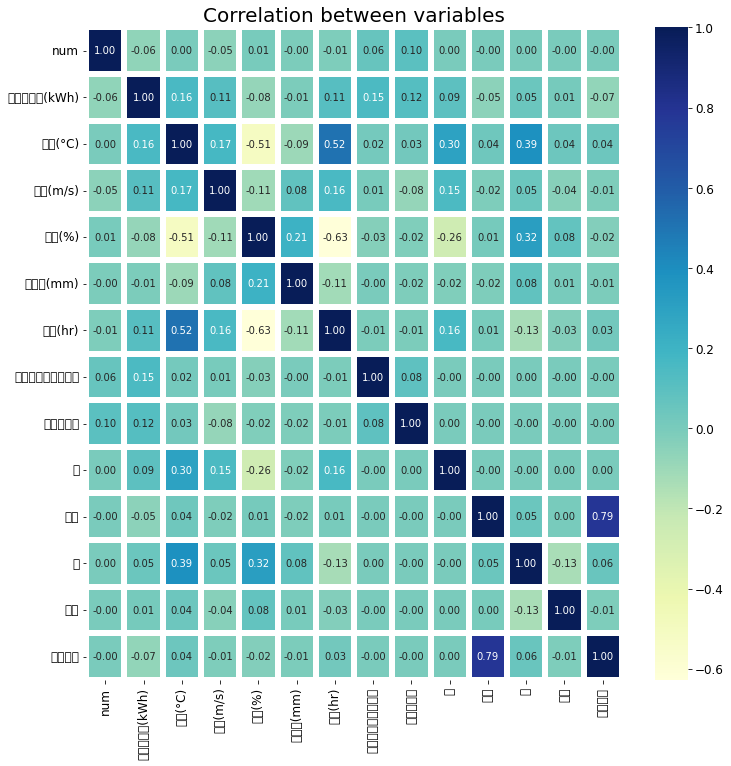

In [ ]:
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(12,12))
sns.heatmap(data=train_prepared.corr(), annot=True, fmt='.2f',linewidths=5,cmap='YlGnBu')
plt.title('Correlation between variables',fontsize=20)
plt.show()

In [ ]:
print(train_prepared[['전력사용량(kWh)','기온(°C)']].corr())

            전력사용량(kWh)    기온(°C)
전력사용량(kWh)    1.000000  0.158361
기온(°C)        0.158361  1.000000


# one hot encoding

In [ ]:
# 원핫 인코딩-꿀팁 sklearn 안써도 됨
train_one = pd.get_dummies(train_prepared)
test_one = pd.get_dummies(test_prepared)
train_one.head()

,num,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,월,일,시,주말여부,요일_0,요일_1,요일_2,요일_3,요일_4,요일_5,요일_6,불쾌지수_범주_낮음,불쾌지수_범주_보통,불쾌지수_범주_높음,불쾌지수_범주_매우높음
0,1,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,6,1,0,0,1,0,0,0,0,0,0,1,0,0,0
1,34,530.388,17.6,2.5,92.0,0.8,0.0,1.0,1.0,6,1,0,0,1,0,0,0,0,0,0,1,0,0,0
2,35,553.824,17.1,2.6,94.0,0.1,0.0,1.0,0.0,6,1,0,0,1,0,0,0,0,0,0,1,0,0,0
3,36,797.472,18.5,1.3,95.0,0.0,0.0,0.0,1.0,6,1,0,0,1,0,0,0,0,0,0,1,0,0,0
4,37,1476.720,19.9,1.9,60.0,0.0,0.0,1.0,1.0,6,1,0,0,1,0,0,0,0,0,0,1,0,0,0


In [ ]:
#target = '전력사용량(kWh)'
X = train_one.drop('전력사용량(kWh)',axis=1)
y = train_one['전력사용량(kWh)']

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,shuffle= False)

In [ ]:
def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

### pycaret으로 모델 추천받기

In [ ]:
from pycaret.regression import *
reg = setup(train_one, target='전력사용량(kWh)')

,Description,Value
0,session_id,2434
1,Target,전력사용량(kWh)
2,Original Data,"(122400, 24)"
3,Missing Values,False
4,Numeric Features,19
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(85679, 25)"


In [ ]:
best_5 = compare_models(sort = 'MAPE',n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,79.1172,2.621770e+04,161.5317,0.9939,0.0820,0.0420,36.542
dt,Decision Tree Regressor,100.9637,4.597031e+04,213.9634,0.9892,0.1105,0.0532,0.606
et,Extra Trees Regressor,122.3199,6.918701e+04,262.6632,0.9837,0.1260,0.0680,30.365
lightgbm,Light Gradient Boosting Machine,222.2676,1.006253e+05,317.1021,0.9764,0.1948,0.1472,0.816
gbr,Gradient Boosting Regressor,563.9512,7.016483e+05,837.4760,0.8355,0.3986,0.3730,7.771
knn,K Neighbors Regressor,901.2196,2.210213e+06,1486.0740,0.4819,0.5438,0.5339,8.138
huber,Huber Regressor,1188.9360,4.151794e+06,2037.2931,0.0263,0.6964,0.6339,2.189
par,Passive Aggressive Regressor,1414.9517,5.198116e+06,2271.2184,-0.2163,1.0446,0.6808,0.146
ridge,Ridge Regression,1282.6684,3.916570e+06,1978.8042,0.0813,0.7348,0.8390,0.048
lr,Linear Regression,1282.6688,3.916577e+06,1978.8061,0.0813,0.7348,0.8390,0.373




# Randomforest

In [ ]:
###packages
from sklearn.ensemble import RandomForestRegressor

#model
model = RandomForestRegressor()
#params
param_dist = {"max_depth": [5,10,30,40],
              "n_estimators": [100,200,300]}

grid_search = GridSearchCV(model, param_grid=param_dist, cv = 3)

#학습
grid_search.fit(X_train, y_train)

grid_search.best_params_

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
model = grid_search.best_estimator_

model.fit(X_train,y_train)

In [ ]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)

smape(y_train,train_pred), smape(y_val,val_pred)

(1.2917553025598256, 8.044035544180113)

In [ ]:
test_pred = model.predict(test_one)

In [ ]:
test_pred

array([8700.86448, 8702.27388, 8701.62588, ..., 3689.4312 , 3588.37992,
       3377.68704])

In [ ]:
##제출 파일 만들기
submission["answer"] = test_pred

submission.to_csv("answer02.csv",index=False)